# langchain + llamaindex 集成 graphrag

python==3.10

参考：https://github.com/tomasonjo/blogs/blob/master/msft_graphrag/ms_graphrag_retriever.ipynb

In [1]:
!pip install --quiet tqdm neo4j seaborn tiktoken shutup numpy pandas openai langchain_openai langchain_community langchain_core llama_index llama-index-vector-stores-chroma llama-index-vector-stores-neo4jvector

In [2]:
import shutup
shutup.please()

import os
import getpass
from neo4j import GraphDatabase, Result
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tiktoken
import numpy as np
from tqdm import tqdm
from typing import Dict, Any
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_community.vectorstores import Neo4jVector
from langchain_community.graphs import Neo4jGraph
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

# pd 展示设置
pd.set_option("display.max_colwidth", None)  # 完整显示每个单元格
pd.set_option("display.max_columns", None)   # 取消了显示列数的限制

In [3]:
NEO4J_URI = "neo4j://localhost:7687"
NEO4J_USERNAME = "neo4j"
NEO4J_PASSWORD = "12345678"

driver = GraphDatabase.driver(NEO4J_URI, auth=(NEO4J_USERNAME, NEO4J_PASSWORD)) # 连接neo4j数据库

# 查询函数定义
def db_query(cypher: str, params: Dict[str, Any] = {}) -> pd.DataFrame:
    return driver.execute_query(
        cypher, parameters_=params, result_transformer_=Result.to_df  # 结果转为pandas.df
    )

In [4]:
os.environ["OPENAI_API_KEY"] = "sk-6n3IuwDfeMEZggn2A61a818dC722474292D929C27004Fe82"
os.environ["OPENAI_BASE_URL"] ="http://localhost:13000/v1"

In [5]:
db_query("MATCH (n:__Chunk__) RETURN n.n_tokens as token_count, count(*) AS count")  # 看看每块token的分布

,token_count,count
0,1200,17
1,907,1
2,1047,1
3,1055,1
4,176,1
5,212,1
6,989,1
7,627,1
8,471,1
9,560,1


In [6]:
db_query(
    "MATCH (n:__Entity__) RETURN n.name AS name, n.description AS description LIMIT 1"  # 基础实体
)

,name,description
0,非法传销,组织或参与非法传销的行为，根据情节轻重可受到不同程度的纪律处分。


In [7]:
db_query("MATCH ()-[n:RELATED]->() RETURN n.description AS description LIMIT 5")  # 基础关系

,description
0,华东理工大学制定了“学生违纪处分规定”，用以规范学生行为，维护学校秩序。
1,该规定是由华东理工大学制定的学生纪律处分的具体规则。
2,上海市奖学金的具体管理办法由华东理工大学制定并实施，用以奖励表现特别优秀的在籍在校全日制本科学生。
3,华东理工大学制定了管理该奖学金的办法，用于奖励特别优秀的学生。
4,学生工作部（处）是华东理工大学的一个重要部门，承担着多项学生服务和支持职能。


In [8]:
db_query(
    """
  MATCH (n:__Community__) 
  RETURN n.title AS title, n.summary AS summary, n.full_content AS full_content LIMIT 1
"""
)  # 基础社区

,title,summary,full_content
0,华东理工大学学生工作部（处）及其奖学金管理方法分析,本报告分析了华东理工大学学生工作部（处）及其管理的《上海市奖学金管理办法》。学生工作部（处）是学校中的核心学生管理部门，负责多项重要职能，包括奖学金评审、德育素质考核、学生资助等。本报告探讨了这些职能如何影响学生事务和机构政策，特别是对经济困难学生的支持。,"# 华东理工大学学生工作部（处）及其奖学金管理方法分析\n\n本报告分析了华东理工大学学生工作部（处）及其管理的《上海市奖学金管理办法》。学生工作部（处）是学校中的核心学生管理部门，负责多项重要职能，包括奖学金评审、德育素质考核、学生资助等。本报告探讨了这些职能如何影响学生事务和机构政策，特别是对经济困难学生的支持。\n\n## 学生工作部（处）的核心职能\n\n学生工作部（处）是学校的关键部门，负责管理和监督学生工作的多个方面，包括奖学金评审、德育素质考核、学生资助等。这表明该部门在学生事务管理中扮演着核心角色，其决策和执行直接影响到学生的学习和生活。[records: Entities (264), Relationships (386, 383, 384, 385, 378, 379, 380, 389)]\n\n## 奖学金管理方法的重要性\n\n《上海市奖学金管理办法》由学生工作部（处）负责解释和执行，旨在确保奖学金评审的公平、公正和透明。这一方法不仅影响到学生的经济支持，还关系到学校的声誉和学生的积极性。因此，该办法的实施效果至关重要。[records: Entities (228), Relationships (370)]\n\n## 投诉机制的有效性\n\n学生工作部（处）设立了投诉电话和投诉邮箱，旨在方便学生和服务对象反馈问题和意见。这些投诉渠道的存在有助于及时发现和解决问题，增强学生对学校管理的信任。然而，实际操作中需要确保这些渠道的有效性和响应速度。[records: Entities (268, 269), Relationships (381, 382, 394, 395)]\n\n## 德育素质考核的作用\n\n学生工作部（处）负责组织实施德育素质考核，这是评估学生政治理论水平和道德素质的重要手段。德育素质考核不仅是学生综合素质评价的一部分，还关系到奖学金评定和其他奖励措施。因此，该考核制度的科学性和公正性尤为重要。[records: Entities (265), Relationships (386, 385)]\n\n## 学生资助的支持作用\n\n学生工作部（处）负责管理学生资助项目，帮助经济困难的学生完成学业。这些资助项目的有效实施对于减轻学生经济负担、促进教育公平具有重要意义。同时，资助项目的透明度和公平性也是衡量其成功与否的重要标准。[records: Entities (266), Relationships (379)]\n\n## 学生成才成长服务的多样性\n\n学生工作部（处）提供的学生成才成长服务旨在促进学生的全面发展和个人成长。这些服务包括职业规划、心理辅导、社会实践等多种形式，有助于学生在学业之外获得全面的发展。[records: Entities (267), Relationships (380)]\n\n## 学费和助学贷款代偿的执行\n\n学生工作部（处）负责解释和执行《高等学校毕业生学费和国家助学贷款代偿暂行办法》，该办法规定了高校毕业生学费和国家助学贷款代偿的具体操作流程。这一政策的实施对于激励学生投身基层服务、促进社会公平具有积极意义。[records: Entities (414), Relationships (389)]\n\n## 学生工作部（处）的内部结构\n\n学生工作部（处）内部设有多个办公室，如受理机构和思想政治教育办公室，分别负责不同的职能。受理机构主要负责处理学生的投诉，而思想政治教育办公室则专注于思想政治教育工作。这种分工有助于提高工作效率，但也需要注意各部门之间的协调合作。[records: Relationships (383)]\n\n## 学生工作部（处）的服务窗口\n\n学生工作部（处）在华东理工大学大学生俱乐部203室设置了专门的受理地址，用于接收学生的投诉。这一地址的设立体现了学校对学生权益的重视，同时也为学生提供了一个便捷的反馈渠道。[records: Relationships (384)]\n\n## 学生成长与发展的综合支持\n\n学生工作部（处）通过多种途径支持学生的全面发展，包括奖学金评审、德育素质考核、学生资助和学生成才成长服务。这些综合措施不仅有助于学生在校期间的成长，也为他们未来的职业发展打下坚实基础。[records: Relationships (378, 379, 380)]"


1. title - 社区的名称
2. summary - 社区的简短描述
3. full_content - 社区的详细信息

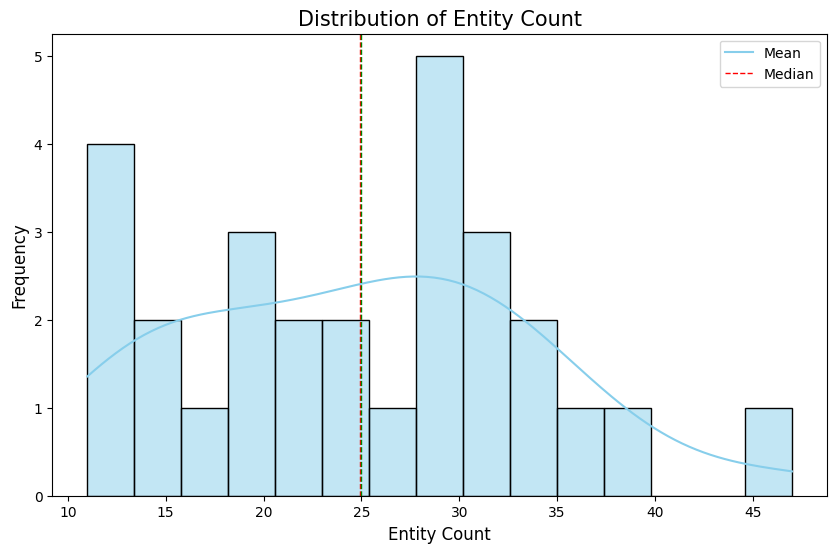

In [9]:
entity_df = db_query(
    """
MATCH (d:__Chunk__)
RETURN count {(d)-[:HAS_ENTITY]->()} AS entity_count
"""
)
# Chunk 与 Entity 的分布关系，即每个Chunk大致包含了多少Entity
plt.figure(figsize=(10, 6))
sns.histplot(entity_df["entity_count"], kde=True, bins=15, color="skyblue")
plt.axvline(
    entity_df["entity_count"].mean(), color="red", linestyle="dashed", linewidth=1
)
plt.axvline(
    entity_df["entity_count"].median(), color="green", linestyle="dashed", linewidth=1
)
plt.xlabel("Entity Count", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.title("Distribution of Entity Count", fontsize=15)
plt.legend(
    {
        "Mean": entity_df["entity_count"].mean(),
        "Median": entity_df["entity_count"].median(),
    }
)
plt.show()

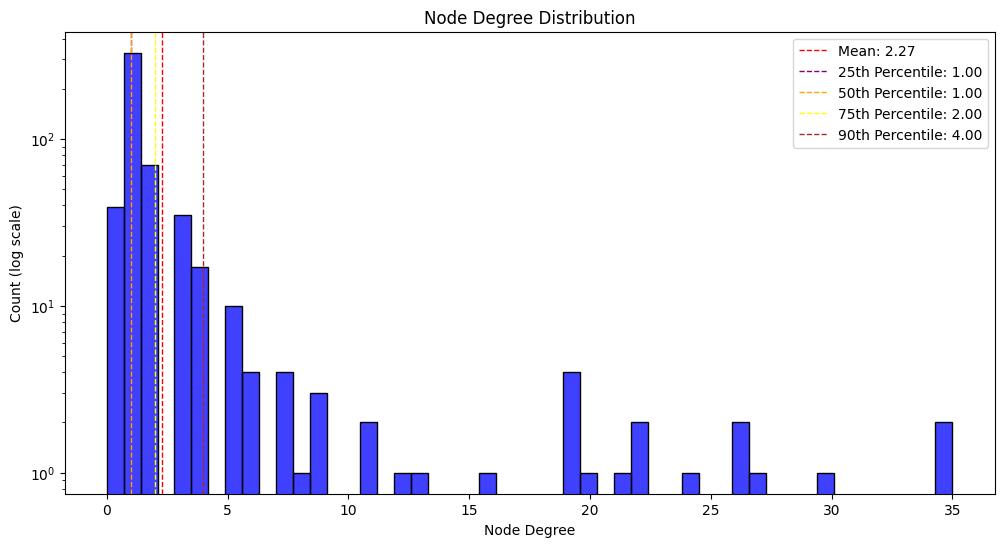

In [10]:
# 查询每个实体节点的关系数量（度）
degree_dist_df = db_query(
    """
MATCH (e:__Entity__)
RETURN count {(e)-[:RELATED]-()} AS node_degree
"""
)
# 计算平均值和各个百分位数
mean_degree = np.mean(degree_dist_df["node_degree"])
percentiles = np.percentile(degree_dist_df["node_degree"], [25, 50, 75, 90])


plt.figure(figsize=(12, 6))
sns.histplot(degree_dist_df["node_degree"], bins=50, kde=False, color="blue")

plt.yscale("log")

plt.xlabel("Node Degree")
plt.ylabel("Count (log scale)")
plt.title("Node Degree Distribution")

plt.axvline(
    mean_degree,
    color="red",
    linestyle="dashed",
    linewidth=1,
    label=f"Mean: {mean_degree:.2f}",
)
plt.axvline(
    percentiles[0],
    color="purple",
    linestyle="dashed",
    linewidth=1,
    label=f"25th Percentile: {percentiles[0]:.2f}",
)
plt.axvline(
    percentiles[1],
    color="orange",
    linestyle="dashed",
    linewidth=1,
    label=f"50th Percentile: {percentiles[1]:.2f}",
)
plt.axvline(
    percentiles[2],
    color="yellow",
    linestyle="dashed",
    linewidth=1,
    label=f"75th Percentile: {percentiles[2]:.2f}",
)
plt.axvline(
    percentiles[3],
    color="brown",
    linestyle="dashed",
    linewidth=1,
    label=f"90th Percentile: {percentiles[3]:.2f}",
)

plt.legend()

plt.show()

In [11]:
# 拥有最多边的节点
db_query(
    """
  MATCH (n:__Entity__) 
  RETURN n.name AS name, count{(n)-[:RELATED]-()} AS degree
  ORDER BY degree DESC LIMIT 5"""
)

,name,degree
0,《华东理工大学本科生奖学金评定条例（试行）》,35
1,国家奖学金,35
2,德育素质考核,30
3,学生申诉处理委员会,27
4,上海市奖学金,26


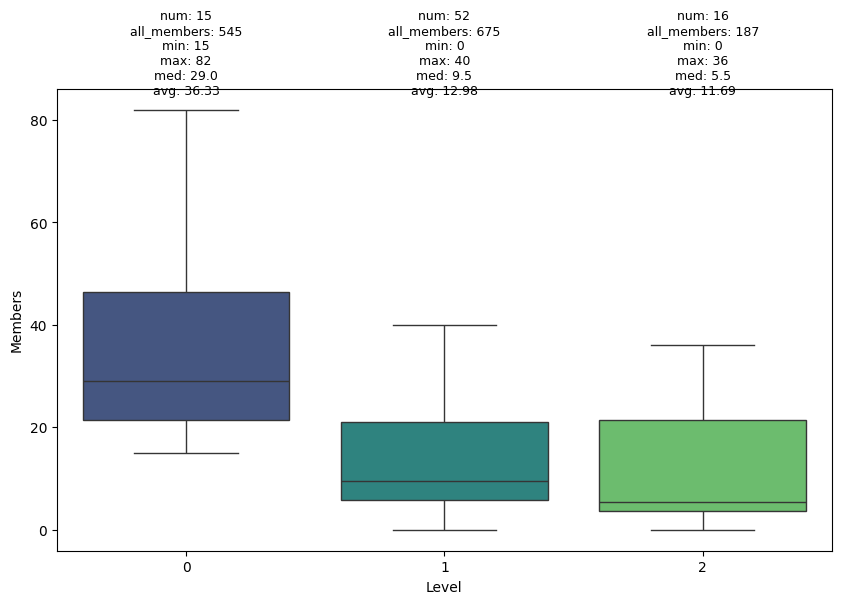

In [12]:
# 分析社区成员数量的分布统计
community_data = db_query(
    """
  MATCH (n:__Community__)
  RETURN n.level AS level, count{(n)-[:IN_COMMUNITY]-()} AS members
"""
)

stats = (
    community_data.groupby("level")
    .agg(
        min_members=("members", "min"),
        max_members=("members", "max"),
        median_members=("members", "median"),
        avg_members=("members", "mean"),
        num_communities=("members", "count"),
        total_members=("members", "sum"),
    )
    .reset_index()
)

plt.figure(figsize=(10, 6))
sns.boxplot(x="level", y="members", data=community_data, palette="viridis")
plt.xlabel("Level")
plt.ylabel("Members")

for i in range(stats.shape[0]):
    level = stats["level"][i]
    max_val = stats["max_members"][i]
    text = (
        f"num: {stats['num_communities'][i]}\n"
        f"all_members: {stats['total_members'][i]}\n"
        f"min: {stats['min_members'][i]}\n"
        f"max: {stats['max_members'][i]}\n"
        f"med: {stats['median_members'][i]}\n"
        f"avg: {stats['avg_members'][i]:.2f}"
    )
    plt.text(level, 85, text, horizontalalignment="center", fontsize=9)

plt.show()

这表明了：
1. 社区规模随层级升高而减小（成员数量减少）
2. 层级0的社区最稠密，成员最多
3. 高层级(1和2)的社区存在空社区(min=0)
4. 社区数量呈现"金字塔"结构：中间层最多，两端较少

要再清晰理解一下，我们直接进行查询：

In [13]:
# 查看社区层级的详细信息
result = db_query("""
    MATCH (n:__Community__)
    RETURN DISTINCT n.level AS level, n.title AS title, n.summary AS summary
    ORDER BY n.level
    LIMIT 3
""")
print(result)

   level                     title  \
0      0         华东理工大学国家励志奖学金管理社区   
1      0  华东理工大学本科生国家励志奖学金管理方法评估报告   
2      0         华东理工大学社会工作奖评选体系分析   

                                                                                                                                         summary  
0                     本社区围绕华东理工大学国家励志奖学金的管理方法展开，涉及多个关键实体和关系，包括奖学金评审委员会、党委学生工作部（处）、国家励志奖学金评审领导小组等。这些实体之间相互协作，共同确保奖学金的公正、透明评审和发放，特别是支持来自经济困难背景的学生。  
1                此社区围绕华东理工大学的学生工作部（处）展开，该部门在奖学金评审、德育素质考核、学生资助及思想政治教育等方面扮演核心角色。学生工作部（处）与其他关键实体如财政部、教育部、教育部全国学生资助管理中心等有紧密联系，共同确保奖学金管理和学生支持工作的顺利实施。  
2  本报告深入分析了华东理工大学的社会工作奖评选体系，涉及评选条例、条件、方法、原则等多个方面。该体系旨在通过评选社会工作奖来提升学生的管理意识和组织能力，促进学生成为复合型人才。主要关系包括华东理工大学作为制定者与学生工作部（处）、团委等相关部门的合作，以及学生参评的具体条件和程序。  


所以，层级代表了：
1. 层级0（基础层）：
例如："华东理工大学国家励志奖学金管理社区"
这是最基础的执行层，直接负责奖学金的具体管理工作
涉及评审委员会、党委学工部等多个实体机构的协作
平均成员数最多(36.33人)，说明这是实际操作层面

2. 层级1（实施层）：
例如："华东理工大学本科生国家励志奖学金管理方法评估报告"
关注管理方法的具体实施和评估
主要处理奖学金评审、素质考核等具体工作
涉及的部门最多(52个社区)，反映了实施环节的复杂性

3. 层级2（制度层）：
例如："华东理工大学社会工作奖评选体系分析"
侧重制度设计和体系分析
负责评选体系的整体规划和设计
成员较少(平均11.69人)，主要是决策和规划层面

以上就是我们利用LLM构建的Graph总览，接下来看local search和global search嵌入langchain 和 llamaindex

## Local Search

图解：

![local](./img/local.png)

多阶段的检索过程：

1. 初始检索阶段(类似传统RAG): 用向量相似度找到最相关的初始实体节点

2. 图扩展阶段(图数据库的优势，这是传统RAG所不具备的能力):

- 从初始节点出发,通过图结构关系向外延展
- 收集相关的文本、报告、实体关系等信息


3. 排序筛选阶段(回归RAG思路):

- 对收集到的所有信息进行相似度排序
- 过滤筛选出最相关的内容

4. 上下文注入阶段:

- 将筛选后的信息和对话历史组织成上下文

In [14]:
# 配置向量索引，加速查询
index_name = "entity"

db_query(
    """
CREATE VECTOR INDEX """
    + index_name
    + """ IF NOT EXISTS FOR (e:__Entity__) ON e.description_embedding
OPTIONS {indexConfig: {
 `vector.dimensions`: 1536,
 `vector.similarity_function`: 'cosine'
}}
"""
)

# vector.dimensions: 1536, 嵌入维度
# vector.similarity_function: 'cosine'，相似度计算方法：余弦相似度

""


In [15]:
# 计算并存储社区权重（社区中实体出现的不同文本块的数量）
# 如果一个社区的实体在更多不同的文本块中被提到，说明这个社区更重要或者更活跃，这个权重可能用于后续的社区排序或筛选
db_query(
    """
MATCH (n:`__Community__`)<-[:IN_COMMUNITY]-()<-[:HAS_ENTITY]-(c)
WITH n, count(distinct c) AS chunkCount
SET n.weight = chunkCount"""
)

topChunks = 3
topCommunities = 3
topOutsideRels = 10
topInsideRels = 10
topEntities = 10

现在，还需对图谱进行向量化。

In [16]:
# 首先设置向量搜索的 index_query
# 使用之前创建的向量索引进行相似度搜索，返回最相似的实体节点和相似度分数
index_query = """
CALL db.index.vector.queryNodes("entity", $k, $vector) 
YIELD node, score
"""

# 然后设置检索的查询，从找到的实体节点出发，收集五类信息
retrieval_query = f"""
WITH collect(node) as nodes
// Entity - Text Unit Mapping
WITH
nodes,
collect {{
    UNWIND nodes as n
    MATCH (n)<-[:HAS_ENTITY]->(c:__Chunk__)
    WITH c, count(distinct n) as freq
    RETURN c.text AS chunkText
    ORDER BY freq DESC
    LIMIT {topChunks}
}} AS text_mapping,

// Entity - Report Mapping
collect {{
    UNWIND nodes as n
    MATCH (n)-[:IN_COMMUNITY]->(c:__Community__)
    WITH c, c.rank as rank, c.weight AS weight
    RETURN c.summary 
    ORDER BY rank, weight DESC
    LIMIT {topCommunities}
}} AS report_mapping,

// Outside Relationships 
collect {{
    UNWIND nodes as n
    MATCH (n)-[r:RELATED]-(m) 
    WHERE NOT m IN nodes
    RETURN r.description AS descriptionText
    ORDER BY r.rank, r.weight DESC 
    LIMIT {topOutsideRels}
}} as outsideRels,

// Inside Relationships 
collect {{
    UNWIND nodes as n
    MATCH (n)-[r:RELATED]-(m) 
    WHERE m IN nodes
    RETURN r.description AS descriptionText
    ORDER BY r.rank, r.weight DESC 
    LIMIT {topInsideRels}
}} as insideRels,

// Entities description
collect {{
    UNWIND nodes as n
    RETURN n.description AS descriptionText
}} as entities

WITH nodes[0] as first_node,
     apoc.text.join(text_mapping, '|') as chunks_text,
     apoc.text.join(report_mapping, '|') as reports_text,
     apoc.text.join(outsideRels + insideRels, '|') as rels_text,
     apoc.text.join(entities, '|') as entities_text

WITH first_node,
     "Chunks:" + chunks_text + 
     "\nReports: " + reports_text +  
     "\nRelationships: " + rels_text + 
     "\nEntities: " + entities_text as full_text

// 构建最终结果，将 node_content 序列化为 JSON 字符串
RETURN 
    full_text AS text,
    1.0 AS score,
    first_node.id AS id,
    {{
        _node_type: "text",
        _node_content: apoc.convert.toJson({{
            id: toString(first_node.id),
            text: full_text,
            metadata: {{}}
        }})
    }} AS metadata
"""

五类信息：

1. `MATCH (n)<-[:HAS_ENTITY]->(c:__Chunk__)`: 文本映射 (Entity-Text)，找到实体相关的文本块，按频率排序取前topChunks个
2. `MATCH (n)-[:IN_COMMUNITY]->(c:__Community__)`：报告映射 (Entity-Report)，找到实体所在的社区信息，按rank和weight排序，取前topCommunities个
3. `MATCH (n)-[r:RELATED]-(m) WHERE NOT m IN nodes`：外部关系 (Outside Relationships)，找到与已知实体相关但不在初始结果中的关系，取前topOutsideRels个
4. `MATCH (n)-[r:RELATED]-(m) WHERE m IN nodes`：内部关系 (Inside Relationships)，找到初始结果实体之间的关系，取前topInsideRels个
5. 实体描述 (Entities)

最后，将所有收集到的信息组合成一个完整的文本，构建包含id、文本和metadata的标准化返回格式。

这个查询实现了完整的Local Retrieval流程：从向量相似度搜索开始，通过图的结构收集相关信息，最后组织成结构化的响应。

In [18]:
from llama_index.embeddings.openai import OpenAIEmbedding
from llama_index.vector_stores.neo4jvector import Neo4jVectorStore
from tqdm import tqdm
import time
import re

def clean_text(text):
    if not isinstance(text, str):
        return ""
    # 清理非打印字符
    text = re.sub(r'[\x00-\x1F\x7F-\x9F]', '', text)
    # 移除多余空白
    text = ' '.join(text.split())
    return text.strip()

def preprocess_embeddings(session, embed_model, max_retries=3):
    # 默认是description, 使用 name 作为备选文本
    result = session.run("""
        MATCH (n:__Entity__)
        WHERE n.description_embedding IS NULL
        RETURN n.id as id, 
               CASE 
                   WHEN n.description IS NOT NULL AND n.description <> '' 
                   THEN n.description 
                   ELSE n.name 
               END as text
    """)
    records = list(result)
    total = len(records)
    failed_nodes = []
    
    if total > 0:
        print(f"开始为 {total} 个节点添加 embedding")
        pbar = tqdm(records, total=total, desc="处理进度")
        for record in pbar:
            retries = 0
            node_id = record["id"]
            
            # 清理文本
            text = clean_text(record["text"])
            if not text:
                print(f"\n节点 {node_id} 文本无效(description和name都为空)，跳过")
                failed_nodes.append((node_id, "文本无效"))
                continue
                
            while retries < max_retries:
                try:
                    embedding = embed_model.get_text_embedding(text)
                    session.run("""
                        MATCH (n:__Entity__ {id: $id})
                        SET n.description_embedding = $embedding
                    """, {"id": node_id, "embedding": embedding})
                    break
                except Exception as e:
                    retries += 1
                    if retries == max_retries:
                        error_msg = str(e)
                        print(f"\n节点 {node_id} 处理失败: {error_msg[:100]}...")
                        failed_nodes.append((node_id, error_msg))
                    else:
                        time.sleep(2)  # 增加重试等待时间

    if failed_nodes:
        print("\n处理失败的节点:")
        for node_id, error in failed_nodes:
            print(f"ID: {node_id}, 错误: {error[:100]}...")
    
    return total, len(failed_nodes)

# 初始化模型和存储
embed_model = OpenAIEmbedding(
    model="text-embedding-3-small", 
    api_base="http://localhost:13000/v1"
)
embed_dim = 1536

# 初始化 Neo4j vector store
neo4j_vector = Neo4jVectorStore(
    NEO4J_USERNAME,
    NEO4J_PASSWORD,
    NEO4J_URI,
    embed_dim,
    index_name="entity",
    retrieval_query=retrieval_query,
    index_query=index_query,
)

with neo4j_vector._driver.session() as session:
    total, failed = preprocess_embeddings(session, embed_model)
    print(f"\n处理完成: 共 {total} 个节点, 失败 {failed} 个")

开始为 507 个节点添加 embedding


处理进度: 100%|███████████████████████████████████████████████████████████████████████| 507/507 [05:47<00:00,  1.46it/s]


处理完成: 共 507 个节点, 失败 0 个


现在完成了向量化，可以开始进行查询了。

In [21]:
from llama_index.embeddings.openai import OpenAIEmbedding
from llama_index.llms.openai import OpenAI
from llama_index.core import VectorStoreIndex

embed_model = OpenAIEmbedding(model="text-embedding-3-small", api_base="http://localhost:13000/v1")
llm = OpenAI(api_base="http://localhost:13000/v1", model="gpt-4o")

# 创建查询引擎并执行查询
loaded_index = VectorStoreIndex.from_vector_store(neo4j_vector).as_query_engine(
   similarity_top_k=topEntities,
   embed_model=embed_model,
   llm=llm
)

response = loaded_index.query("国家奖学金的申请条件？")
print(response.response)  # 参考：response.source_nodes[0].text

国家奖学金的申请条件包括以下几点：申请者必须具有中华人民共和国国籍，热爱社会主义祖国并拥护中国共产党的领导，遵守宪法和法律以及学校规章制度，诚实守信且道德品质优良。在校期间，申请者的学习成绩必须优异，上一学年的学习成绩排名和综合考评成绩排名均需位于前10%。此外，申请者上一学年需获得社会工作B等奖及以上或获得省（市）、部级及以上竞赛奖励。对于在某些方面表现特别优秀的学生，即使学习成绩排名未达到前10%但达到前30%，也可以申请国家奖学金，前提是符合其他条件并经过学校相关部门的综合认定。


# Global Search

图解：

![global](./img/global.png)

1. Map阶段(并行处理):

- 接收用户查询和历史对话
- 将这些输入并行分发到不同的、被打乱的Community批次中处理
- 每个批次独立生成带评分的中间响应(RIR)


2. Reduce阶段(归并处理):

- 收集所有中间响应
- 通过排序和过滤筛选出最相关的内容
- 将筛选后的内容聚合成最终响应

这样，可以高效地并行处理大量社区数据，通过评分机制可以确保质量，最终通过归并得到一个综合的答案。

这和传统的MapReduce很像,只是这里处理的是文本/语义信息而不是普通的数据计算。整个流程保证了即使面对大量社区数据,也能高效地找到最相关的信息并生成高质量的响应。

### 两种搜索方式对比

| 特征 | Local Search | Global Search |
|---------|--------------|---------------|
| 搜索范围 | 仅相关性高的局部社区 | 所有社区 |
| 处理策略 | 深度优先，沿相关路径探索 | 广度优先，并行处理所有社区 |
| 处理方式 | 串行处理局部社区信息 | MapReduce式并行处理 |
| 响应速度 | 较快，因为只处理部分数据 | 较慢，需要处理全部数据 |
| 信息完整性 | 可能会遗漏其他社区信息 | 更全面，不会遗漏信息 |
| 计算开销 | 较小，集中在相关社区 | 较大，需处理所有社区 |
| 适用场景 | 快速响应、目标明确的查询 | 需要全面信息汇总的查询 |
| 结果质量 | 依赖于初始社区选择的准确性 | 更稳定，不依赖初始选择 |
| 扩展性 | 较好，可以控制搜索深度 | 一般，需要处理所有数据 |
| 实现复杂度 | 相对简单 | 相对复杂，需要并行处理框架 |

In [22]:
llm = ChatOpenAI(model="qwen2.5:32b")  # langchain 兼容本地模型，使用本地ollama查询

In [23]:
MAP_SYSTEM_PROMPT = """
---Role---

你是一个助手，负责回答关于所提供表格数据的问题。


---Goal---

生成一个由关键点列表组成的回应，回答用户的问题，总结输入数据表中的所有相关信息。

你应该使用下面提供的数据表作为生成回应的主要依据。
如果你不知道答案，或者输入的数据表没有足够的信息来提供答案，请直接说明。不要编造任何内容。

回应中的每个关键点都应该包含以下元素：
- 描述：对该点的全面描述。
- 重要性分数：一个0-100之间的整数分数，表示该点在回答用户问题时的重要程度。"我不知道"类型的回应应该得分为0。

回应应按以下JSON格式编写：
{{
    "points": [
        {{"description": "第1点的描述 [数据：报告 (报告编号)]", "score": 分数值}},
        {{"description": "第2点的描述 [数据：报告 (报告编号)]", "score": 分数值}}
    ]
}}

回应应保持情态动词如"应该"、"可能"或"将要"等的原始含义和用法。

有数据支持的观点应按以下方式列出相关报告作为参考：
"这是一个有数据参考支持的示例句子 [数据：报告 (报告编号)]"

**在单个参考中不要列出超过5个记录编号**。应该列出最相关的前5个记录编号，并添加"+更多"来表示还有更多记录。

例如：
"X先生是Y公司的所有者，且面临多项不当行为指控 [数据：报告 (2, 7, 64, 46, 34, +更多)]。他同时也是X公司的CEO [数据：报告 (1, 3)]"

其中1、2、3、7、34、46和64代表提供的表格中相关数据报告的编号（不是索引）。

不要包含没有支持证据的信息。


---Data tables---

{context_data}

---Goal---

生成一个由关键点列表组成的回应，回答用户的问题，总结输入数据表中的所有相关信息。

你应该使用下面提供的数据表作为生成回应的主要依据。
如果你不知道答案，或者输入的数据表没有足够的信息来提供答案，请直接说明。不要编造任何内容。

回应中的每个关键点都应该包含以下元素：
- 描述：对该点的全面描述。
- 重要性分数：一个0-100之间的整数分数，表示该点在回答用户问题时的重要程度。"我不知道"类型的回应应该得分为0。

回应应保持情态动词如"应该"、"可能"或"将要"等的原始含义和用法。

有数据支持的观点应按以下方式列出相关报告作为参考：
"这是一个有数据参考支持的示例句子 [数据：报告 (报告编号)]"

**在单个参考中不要列出超过5个记录编号**。应该列出最相关的前5个记录编号，并添加"+更多"来表示还有更多记录。

例如：
"X先生是Y公司的所有者，且面临多项不当行为指控 [数据：报告 (2, 7, 64, 46, 34, +更多)]。他同时也是X公司的CEO [数据：报告 (1, 3)]"

其中1、2、3、7、34、46和64代表提供的表格中相关数据报告的编号（不是索引）。

不要包含没有支持证据的信息。

回应应按以下JSON格式编写：
{{
    "points": [
        {{"description": "第1点的描述 [数据：报告 (报告编号)]", "score": 分数值}},
        {{"description": "第2点的描述 [数据：报告 (报告编号)]", "score": 分数值}}
    ]
}}
"""

map_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            MAP_SYSTEM_PROMPT,
        ),
        (
            "human",
            "{question}",
        ),
    ]
)

map_chain = map_prompt | llm | StrOutputParser()  # langchain 管道，数据流向：map_prompt -> llm -> answer -> parser

In [24]:
REDUCE_SYSTEM_PROMPT = """
---Role---

你是一个助手，通过综合多个分析的观点来回答关于数据集的问题。


---Goal---

根据目标长度和格式要求生成回应，回答用户的问题，总结来自多位关注数据集不同部分的分析师的所有报告。

请注意，下面提供的分析师报告按**重要性降序**排列。

如果你不知道答案，或者提供的报告没有足够的信息来提供答案，请直接说明。不要编造任何内容。

最终回应应该删除分析师报告中所有不相关的信息，并将整理后的信息合并成一个全面的答案，根据回应长度和格式要求适当地解释所有关键点和含义。

根据长度和格式要求适当添加章节和评论。使用markdown格式编写回应。

回应应保持情态动词如"应该"、"可能"或"将要"等的原始含义和用法。

回应还应保留分析师报告中此前包含的所有数据引用，但不要提及多位分析师在分析过程中的角色。

**在单个参考中不要列出超过5个记录编号**。应该列出最相关的前5个记录编号，并添加"+更多"来表示还有更多记录。

例如：
"X先生是Y公司的所有者，且面临多项不当行为指控 [数据：报告 (2, 7, 34, 46, 64, +更多)]。他同时也是X公司的CEO [数据：报告 (1, 3)]"

其中1、2、3、7、34、46和64代表相关数据记录的编号（不是索引）。

不要包含没有支持证据的信息。


---Target response length and format---

{response_type}


---Analyst Reports---

{report_data}


---Goal---

根据目标长度和格式要求生成回应，回答用户的问题，总结来自多位关注数据集不同部分的分析师的所有报告。

请注意，下面提供的分析师报告按**重要性降序**排列。

如果你不知道答案，或者提供的报告没有足够的信息来提供答案，请直接说明。不要编造任何内容。

最终回应应该删除分析师报告中所有不相关的信息，并将整理后的信息合并成一个全面的答案，根据回应长度和格式要求适当地解释所有关键点和含义。

回应应保持情态动词如"应该"、"可能"或"将要"等的原始含义和用法。

回应还应保留分析师报告中此前包含的所有数据引用，但不要提及多位分析师在分析过程中的角色。

**在单个参考中不要列出超过5个记录编号**。应该列出最相关的前5个记录编号，并添加"+更多"来表示还有更多记录。

例如：
"X先生是Y公司的所有者，且面临多项不当行为指控 [数据：报告 (2, 7, 34, 46, 64, +更多)]。他同时也是X公司的CEO [数据：报告 (1, 3)]"

其中1、2、3、7、34、46和64代表相关数据记录的编号（不是索引）。

不要包含没有支持证据的信息。


---Target response length and format---

{response_type}

根据长度和格式要求适当添加章节和评论。使用markdown格式编写回应。
"""

reduce_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            REDUCE_SYSTEM_PROMPT,
        ),
        (
            "human",
            "{question}",
        ),
    ]
)
reduce_chain = reduce_prompt | llm | StrOutputParser()

In [25]:
graph = Neo4jGraph(
    url=NEO4J_URI,
    username=NEO4J_USERNAME,
    password=NEO4J_PASSWORD,
    refresh_schema=False,
)

response_type: str = "multiple paragraphs" # # 默认响应类型为多段落

# 传参: 问题 + 要搜索的问题社区等级
def global_retriever(query: str, level: int, response_type: str = response_type) -> str:
    community_data = graph.query(
        """
    MATCH (c:__Community__)
    WHERE c.level = $level
    RETURN c.full_content AS output
    """,
        params={"level": level},
    )
    intermediate_results = []  # 中间结果
    # 对每个社区，调用 map_chain 处理查询和社区内容
    for community in tqdm(community_data, desc="Processing communities"):
        intermediate_response = map_chain.invoke(
            {"question": query, "context_data": community["output"]}
        )
        intermediate_results.append(intermediate_response)
    # 综合每片回答    
    final_response = reduce_chain.invoke(
        {
            "report_data": intermediate_results,
            "question": query,
            "response_type": response_type,
        }
    )
    return final_response

In [26]:
print(global_retriever("国家奖学金的申请条件？", 0))


rocessing communities: 100%|███████████████████████████████████████████████████████████| 15/15 [01:07<00:00,  4.47s/it]

 国家奖学金由中央政府出资设立，旨在奖励特别优秀的学生。其基本申请条件包括：

1. 热爱社会主义祖国，拥护中国共产党的领导；
2. 遵守宪法和法律，遵守学校规章制度；
3. 诚实守信，道德品质优良；
4. 在校期间学习成绩优异，社会实践、创新能力、综合素质等方面表现突出。

此外，具体条件要求由各省市自行规定。值得注意的是，国家奖学金奖励特别优秀的全日制本专科生（含高职、第二学士学位），每年全国共奖励本专科学生5万名，每生每年8000元 [数据：报告 (47, 50, 115, 131)]。

尽管有多个分析师对不同类型的奖学金进行了分析，比如国家励志奖学金和学费补偿及国家助学贷款代偿等，但有关国家奖学金的具体申请条件信息主要集中在上述几点。因此，这些是目前可以确认的国家奖学金的基本申请要求 [数据：报告 (5, 106, 347)]。

若需要更详细的申请条件，可能还需参考各省市或具体学校的规定。


In [27]:
print(global_retriever("国家奖学金的申请条件？", 1))


rocessing communities: 100%|███████████████████████████████████████████████████████████| 52/52 [03:41<00:00,  4.26s/it]

 国家奖学金由中央政府出资设立，奖励特别优秀的学生，其申请的基本条件包括：

1. 热爱社会主义祖国，拥护中国共产党的领导；

2. 遵守宪法和法律，遵守学校规章制度；

3. 诚实守信，道德品质优良；

4. 在校期间学习成绩优异，社会实践、创新能力、综合素质等方面特别突出。

另外，在学习成绩优异的具体要求如下：

1. 学习成绩排名与综合考评成绩排名均位于前10%（含），可以申请国家奖学金。
2. 学习成绩排名或综合考评成绩排名超出前10%，但均位于前30%（含）的，必须在道德风尚、学术研究、学科竞赛、创新发明、社会实践、社会工作、体育竞赛、艺术展演等某一方面表现特别优秀，方可申请国家奖学金。


In [28]:
print(global_retriever("国家奖学金的申请条件？", 2))


rocessing communities: 100%|███████████████████████████████████████████████████████████| 16/16 [01:17<00:00,  4.87s/it]

 国家奖学金由中央政府出资设立，奖励特别优秀的学生，其申请的基本条件有：

1. 热爱社会主义祖国，拥护中国共产党的领导；

2. 遵守宪法和法律，遵守学校规章制度；

3. 诚实守信，道德品质优良；

4. 在校期间学习成绩优异，社会实践、创新能力、综合素质等方面特别突出。


我们只有0,1,2三个level的社区，具体可参见之前画的community分布，level 1 节点最多，查询最慢：

```
Level 3 (高层):     [少量大社区]
                        ↓
Level 2 (中层):   [大量中等社区]   <- 这里处理最慢
                        ↓
Level 1 (底层):     [少量小社区]
```

所以：
- 可以先用之前的cypher查询看看每个level的社区数量分布
- 根据实际查询需求和性能要求来选择合适的level
- 如果对中层处理太慢，可以考虑添加过滤条件或者分批处理

In [29]:
driver.close() # 关闭neo4j的连接